In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt

# Data Import

In [ ]:
# Parameters
remove_outliers = True
quantile_outlier_remove = 0.001

# Error costs
cost_fp = 1   # Cost of a legitimate transaction being classified as fraud
cost_fn = 10  # Cost of a fraudulent transaction being classified as legitimate

In [2]:
!kaggle datasets download -d gzdekzlkaya/credit-card-fraud-detection-dataset
import zipfile

with zipfile.ZipFile("credit-card-fraud-detection-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("credit_fraud_data")

Dataset URL: https://www.kaggle.com/datasets/gzdekzlkaya/credit-card-fraud-detection-dataset
License(s): CC-BY-SA-4.0
credit-card-fraud-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
df = pd.read_csv("credit_fraud_data/creditcard_fraud_detection.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data Analysis

Features:
- V1 to V28: PCA-transformed features
- Amount: Transaction amount
- Time: Time since first transaction
- Class: Target (0 = legitimate, 1 = fraud)

In [4]:
df.describe().round(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,...,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000
mean,94813.8596,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,...,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,88.3496,0.0017
std,47488.1460,1.9587,1.6513,1.5163,1.4159,1.3802,1.3323,1.2371,1.1944,1.0986,...,0.7345,0.7257,0.6245,0.6056,0.5213,0.4822,0.4036,0.3301,250.1201,0.0415
min,0.0000,-56.4075,-72.7157,-48.3256,-5.6832,-113.7433,-26.1605,-43.5572,-73.2167,-13.4341,...,-34.8304,-10.9331,-44.8077,-2.8366,-10.2954,-2.6046,-22.5657,-15.4301,0.0000,0.0000
25%,54201.5000,-0.9204,-0.5985,-0.8904,-0.8486,-0.6916,-0.7683,-0.5541,-0.2086,-0.6431,...,-0.2284,-0.5424,-0.1618,-0.3546,-0.3171,-0.3270,-0.0708,-0.0530,5.6000,0.0000
50%,84692.0000,0.0181,0.0655,0.1798,-0.0198,-0.0543,-0.2742,0.0401,0.0224,-0.0514,...,-0.0295,0.0068,-0.0112,0.0410,0.0166,-0.0521,0.0013,0.0112,22.0000,0.0000
75%,139320.5000,1.3156,0.8037,1.0272,0.7433,0.6119,0.3986,0.5704,0.3273,0.5971,...,0.1864,0.5286,0.1476,0.4395,0.3507,0.2410,0.0910,0.0783,77.1650,0.0000
max,172792.0000,2.4549,22.0577,9.3826,16.8753,34.8017,73.3016,120.5895,20.0072,15.5950,...,27.2028,10.5031,22.5284,4.5845,7.5196,3.5173,31.6122,33.8478,25691.1600,1.0000


In [5]:
print("Number of rows: ", df.shape[0])
print("Number of fraudulent transactions: ", df[df['Class'] == 1].shape[0])

Number of rows:  284807
Number of fraudulent transactions:  492


Analyzing the correlation between the variables and the Class feature and filtering for the 1%+ corrrelated.

In [6]:
correlations = df.corr(numeric_only=True)['Class'].drop('Class').sort_values(ascending=False)
correlations001 = correlations[correlations.abs() >= 0.01]
print(correlations001)

V11     0.154876
V4      0.133447
V2      0.091289
V21     0.040413
V19     0.034783
V20     0.020090
V8      0.019875
V27     0.017580
Time   -0.012323
V6     -0.043643
V5     -0.094974
V9     -0.097733
V1     -0.101347
V18    -0.111485
V7     -0.187257
V3     -0.192961
V16    -0.196539
V10    -0.216883
V12    -0.260593
V14    -0.302544
V17    -0.326481
Name: Class, dtype: float64


Now, keeping on the df only the features above.

In [7]:
selected_columns = correlations001.index.tolist()
selected_columns.append('Class')

df = df[selected_columns]

Analyzing the outlier nonfraud cases and removing them from df.

In [ ]:
if remove_outliers:
    df_nonfraud = df[df['Class'] == 0].copy()
    df_fraud = df[df['Class'] == 1].copy()

    # Columns to evaluate outliers analysis
    cols = df_nonfraud.columns.drop(['Class','Time'])

    # Create a boolean mask: True if row is NOT an outlier in any column
    mask = pd.Series([True] * len(df_nonfraud), index=df_nonfraud.index)

    # Loop over each column to find and remove 0.1% tails
    for col in cols:
        lower = df_nonfraud[col].quantile(quantile_outlier_remove)
        upper = df_nonfraud[col].quantile(1-quantile_outlier_remove)
        col_mask = (df_nonfraud[col] >= lower) & (df_nonfraud[col] <= upper)
        mask = mask & col_mask  # keep only rows within bounds for all columns

    # Filter nonfraud rows to exclude outliers
    df_nonfraud_cleaned = df_nonfraud[mask]

    # Combine with untouched fraud cases
    df = pd.concat([df_nonfraud_cleaned, df_fraud], ignore_index=True)

    print(f"Original nonfraud: {df_nonfraud.shape[0]}")
    print(f"Cleaned nonfraud:  {df_nonfraud_cleaned.shape[0]}")
    print(f"Outliers removed:  {df_nonfraud.shape[0] - df_nonfraud_cleaned.shape[0]}")

else:
    print("Outlier removal skipped.")

Original nonfraud: 284315
Cleaned nonfraud:  278234
Outliers removed:  6081


`df` is now ready to be used at each predictive model.

# Logistic Regression

Analysis of correlation between the predictive variables based on VIF.

| VIF  | Interpretation                    |
| ---- | --------------------------------- |
| 1    | No multicollinearity              |
| 1–5  | Moderate correlation (usually OK) |
| 5–10 | Concerning — check that feature   |
| >10  | Problematic — strong collinearity |


In [36]:
X = df.drop(columns='Class')

# Standardize features to improve stability
from sklearn.preprocessing import StandardScaler
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# Add constant for statsmodels
X_const = add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]

print(vif_data)


   feature       VIF
0    const  1.000000
1      V11  1.100180
2       V4  1.056541
3       V2  1.155098
4      V21  1.034565
5      V19  1.015318
6      V20  1.143984
7       V8  1.050942
8      V27  1.031940
9     Time  1.562847
10      V6  1.155688
11      V5  1.247599
12      V9  1.043921
13      V1  1.212707
14     V18  1.020424
15      V7  1.218729
16      V3  1.385468
17     V16  1.039844
18     V10  1.055782
19     V12  1.040558
20     V14  1.050773
21     V17  1.023802


There are no variables to be removed by multicollinearity.

Starting the model fit.

In [37]:
X = df.drop(columns='Class')
y = df['Class']

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=35, stratify=y
)

Stepwise logistic regression

In [38]:
def stepwise_selection(X, y, threshold_in=0.05, verbose=True):
    included = []
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)

        for new_col in excluded:
            model = sm.Logit(y, sm.add_constant(X[included + [new_col]])).fit(disp=0)
            new_pval[new_col] = model.pvalues[new_col]

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f"Add {best_feature:>10} with p-value {best_pval:.4f}")

        if not changed:
            break
    return included

# Run on training set
selected_features = stepwise_selection(X_train, y_train)


Add         V7 with p-value 0.0000
Add        V10 with p-value 0.0000
Add         V4 with p-value 0.0000
Add        V14 with p-value 0.0000
Add        V12 with p-value 0.0000
Add        V16 with p-value 0.0000
Add         V8 with p-value 0.0000
Add         V2 with p-value 0.0002
Add        V17 with p-value 0.0066
Add        V11 with p-value 0.0022
Add        V21 with p-value 0.0464


Cross-validation with selected features

In [39]:
model_cv = LogisticRegression(max_iter=1000, solver='liblinear')

cv_stats = ['roc_auc','f1','recall','balanced_accuracy']

for stat in cv_stats:
    cv_scores = cross_val_score(model_cv, X_train[selected_features], y_train, 
                                cv=5, scoring=stat)
    print(f"Cross-validated {stat}:", np.round(cv_scores.mean(), 4), cv_scores)

Cross-validated roc_auc: 0.9823 [0.9847944  0.99024637 0.96448633 0.98534908 0.98663631]
Cross-validated f1: 0.9098 [0.95302013 0.87943262 0.88888889 0.8951049  0.93243243]
Cross-validated recall: 0.8377 [0.91025641 0.78481013 0.81012658 0.81012658 0.87341772]
Cross-validated balanced_accuracy: 0.9189 [0.95512821 0.89240506 0.90505206 0.90506329 0.93670886]


Final model fitting and prediction

In [44]:
model_final = LogisticRegression(max_iter=1000, solver='liblinear')
model_final.fit(X_train[selected_features], y_train)

y_pred = model_final.predict(X_test[selected_features])
y_proba = model_final.predict_proba(X_test[selected_features])[:, 1]

Gets best threshold based on FP and FN costs

In [ ]:
thresholds = np.linspace(0.01, 0.99, 99)
costs = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    costs.append(total_cost)

# Best threshold
best_index = np.argmin(costs)
best_threshold = thresholds[best_index]
print(f"Best threshold = {best_threshold:.2f} with total cost = {costs[best_index]}")
# print(f"Confusion Matrix at Best Threshold:\n{confusion_matrix(y_test, (y_proba >= best_threshold).astype(int))}")

Best threshold = 0.08 with total cost = 217
Confusion Matrix at Best Threshold:
[[55641     7]
 [   21    77]]


Evaluation metrics

Accuracy: 0.9994977218096366
ROC AUC: 0.9757904275856404
Confusion Matrix:
 [[55641     7]
 [   21    77]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     55648
           1       0.92      0.79      0.85        98

    accuracy                           1.00     55746
   macro avg       0.96      0.89      0.92     55746
weighted avg       1.00      1.00      1.00     55746



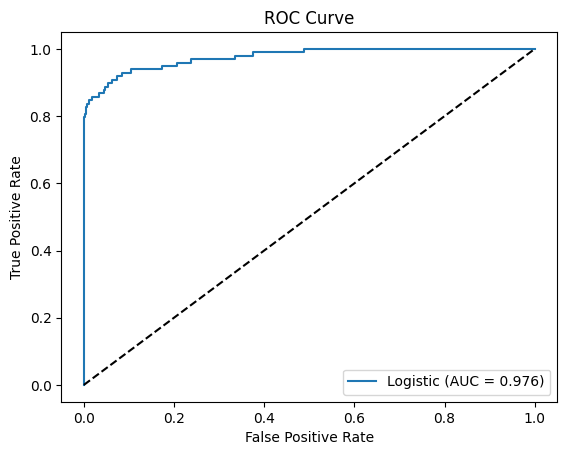

In [51]:
y_pred = (y_proba >= best_threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='Logistic (AUC = {:.3f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

Goodness of fit

In [53]:
X_train_sm = sm.add_constant(X_train[selected_features])
model_sm = sm.Logit(y_train, X_train_sm).fit()
print(model_sm.summary())

# Pseudo R-squared (McFadden)
print("McFadden R²:", model_sm.prsquared)


Optimization terminated successfully.
         Current function value: 0.001963
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:               222980
Model:                          Logit   Df Residuals:                   222968
Method:                           MLE   Df Model:                           11
Date:                Sun, 25 May 2025   Pseudo R-squ.:                  0.8486
Time:                        12:41:40   Log-Likelihood:                -437.62
converged:                       True   LL-Null:                       -2891.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.7123      0.233    -41.673      0.000     -10.169      -9.255
V7            -0.1034      0

Export Coefficients, Odds Ratios and P-values

In [ ]:
# Coefficients and p-values
coefs = model_sm.params
pvals = model_sm.pvalues
odds_ratios = np.exp(coefs)

# Combine into a summary DataFrame
summary_df = pd.DataFrame({
    'Feature': coefs.index,
    'Coefficient': coefs.values,
    'Odds Ratio': odds_ratios,
    'P-Value': pvals
}).sort_values(by='P-Value')

print(summary_df)


Optimization terminated successfully.
         Current function value: 0.001963
         Iterations 14
      Feature  Coefficient  Odds Ratio       P-Value
const   const    -9.712268    0.000061  0.000000e+00
V14       V14    -1.105015    0.331206  1.799008e-28
V4         V4     1.206276    3.341019  7.976078e-21
V8         V8    -0.442683    0.642311  2.711696e-13
V12       V12    -0.792514    0.452705  5.667241e-12
V10       V10    -0.771973    0.462100  3.634173e-08
V2         V2    -0.292882    0.746110  2.505880e-04
V16       V16    -0.489718    0.612799  4.404653e-04
V11       V11     0.381967    1.465164  1.523507e-03
V17       V17    -0.296018    0.743774  5.725832e-03
V21       V21     0.097840    1.102786  4.640595e-02
V7         V7    -0.103373    0.901791  2.986682e-01


# Random forest

Since there is no correlated variables (and also givem that tree based models are not sensible for this), it's able to use already the same datasets splitted for logistic regression: X_train, X_test, y_train, y_test.

In [ ]:
model_cv = RandomForestClassifier(
    n_estimators=199,   # Number of trees in the forest
    max_depth=None,     # Expand until all leaves are pure
    random_state=92,    # For reproducibility
    n_jobs=-1           # Use all processors for parallelism
)

cv_stats = ['roc_auc', 'f1', 'recall', 'balanced_accuracy']

for stat in cv_stats:
    cv_scores = cross_val_score(model_cv, X_train[selected_features], y_train, 
                                cv=5, scoring=stat)
    print(f"Cross-validated {stat}:", np.round(cv_scores.mean(), 4), cv_scores)